## Tweet Emotion Recognition: Natural Language Processing with TensorFlow


## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset('emotion')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [64]:
DATA = {0: "sadness", 2:"love", 1:"joy", 3:"anger", 4:"fear", 5:"surprise"}

In [ ]:
def get_tweets(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[0], labels[0]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was',
  'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  'i feel as confused about life as a teenager or as jaded as a year old man',
  'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  'i feel romantic too'],
 [0, 0, 3, 2, 3, 0, 5, 4, 1, 2])

## Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

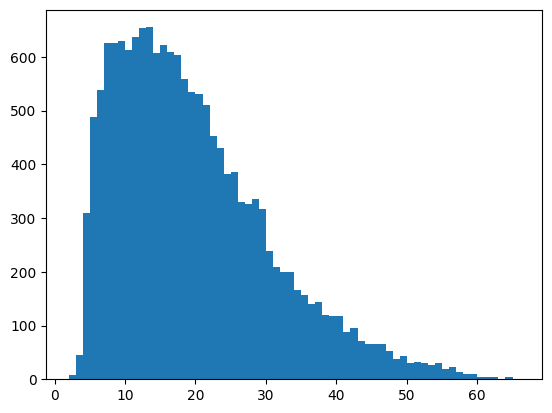

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', maxlen=maxlen, padding='post')
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}
[0, 0, 3, 2, 3, 0, 5, 4, 1, 2, 0, 1, 3, 0, 1, 1, 0, 0, 0, 4, 3, 4, 1, 1, 3, 0, 0, 0, 3, 1, 1, 4, 5, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 3, 1, 0, 3, 4, 1, 0, 0, 5, 1, 1, 1, 2, 4, 4, 5, 3, 3, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 0, 4, 2, 3, 0, 3, 2, 0, 1, 1, 0, 3, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 4, 4, 4, 0, 2, 1, 1, 2, 4, 5, 1, 1, 1, 1, 3, 4, 1, 3, 2, 3, 0, 1, 0, 3, 1, 5, 0, 3, 3, 0, 1, 4, 1, 1, 4, 0, 5, 5, 1, 3, 4, 3, 0, 3, 0, 4, 0, 1, 5, 4, 1, 3, 1, 3, 1, 4, 4, 0, 1, 1, 0, 5, 1, 4, 1, 0, 1, 1, 1, 4, 1, 5, 1, 3, 0, 0, 1, 3, 0, 1, 1, 5, 1, 4, 1, 4, 0, 4, 2, 0, 4, 2, 0, 0, 3, 1, 2, 3, 0, 5, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 3, 5, 1, 3, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 4, 0, 3, 0, 3, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 1, 2, 0, 3, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 4, 0, 4, 1, 1, 4, 1, 3, 3, 2, 0, 5, 1, 3, 0, 0, 3, 2, 5, 0, 2, 1, 3, 1, 0, 0, 1, 1, 4,

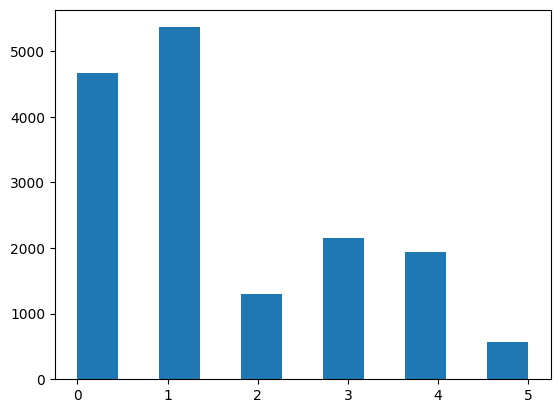

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes = list(classes)
names_to_ids = lambda labels: np.array([classes[x] for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, maxlen))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3645 - loss: 1.5657 - val_accuracy: 0.6130 - val_loss: 1.0400
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6924 - loss: 0.8638 - val_accuracy: 0.7235 - val_loss: 0.7671
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8432 - loss: 0.4848 - val_accuracy: 0.8320 - val_loss: 0.5067
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9103 - loss: 0.2726 - val_accuracy: 0.8660 - val_loss: 0.4407
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9443 - loss: 0.1837 - val_accuracy: 0.8815 - val_loss: 0.3926
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9602 - loss: 0.1327 - val_accuracy: 0.8855 - val_loss: 0.3990
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9684 - loss: 0.0998 - val_accuracy: 0.8865 - val_loss: 0.4241
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9768 - loss: 0.0803 - val_a

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

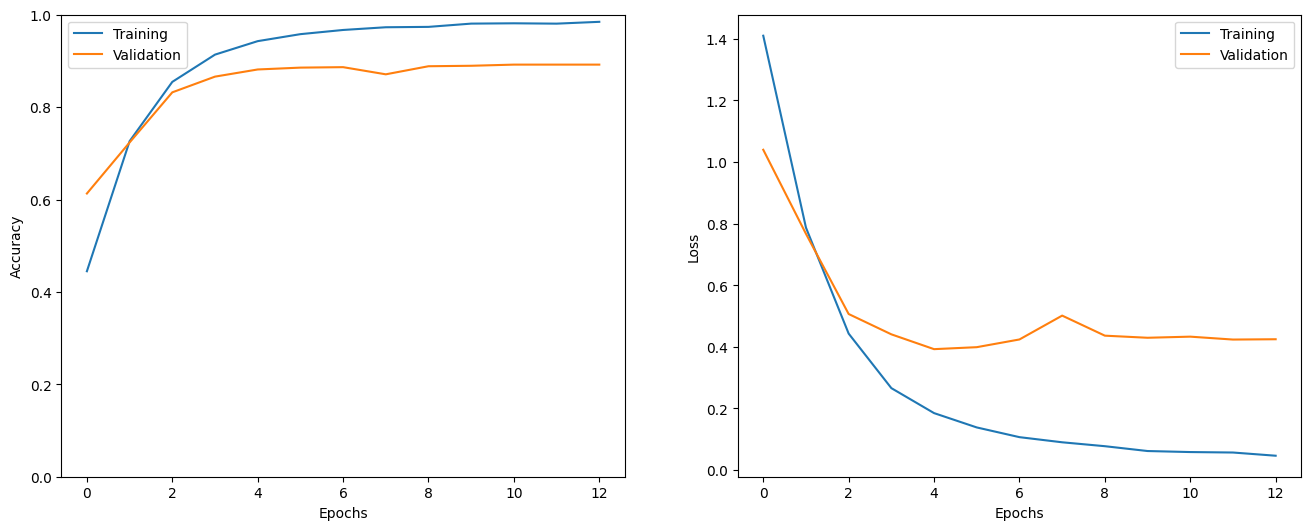

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8811 - loss: 0.4842


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', classes[test_labels[i]])

Sentence: i really feel like we were successful in identifying some pretty scary early warning signs and sticking our foot in the door before it shut
Emotion: 1


In [ ]:
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


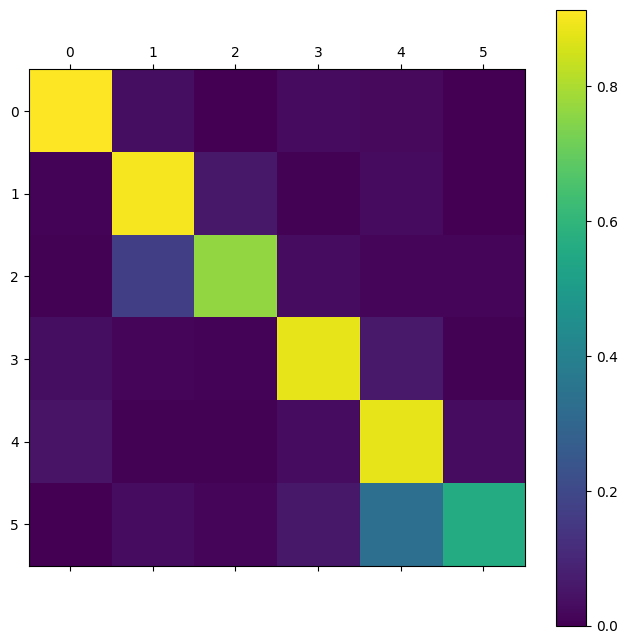

{0: 'sadness', 2: 'love', 1: 'joy', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [66]:
show_confusion_matrix(test_labels, preds.argmax(axis=1), list(classes))
print(DATA)